In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1
import kapre
from kapre.composed import get_melspectrogram_layer
import tensorflow as tf
import os
from tensorflow import keras
from glob import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from scipy.io import wavfile
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
# Currently, memory growth needs to be the same across GPUs
for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])

In [3]:
N_CLASSES=13
SR=16000
DT=10.0

In [4]:


input_shape = (160000,1)
i = get_melspectrogram_layer(input_shape=input_shape,
                             n_mels=128,
                             pad_end=True,
                             n_fft=512,
                             win_length=400,
                             hop_length=160,
                             sample_rate=SR,
                             return_decibel=True,
                             input_data_format='channels_last',
                             output_data_format='channels_last')
x = LayerNormalization(axis=2, name='batch_norm')(i.output)
x = layers.Conv2D(16, kernel_size=(7,7), activation='tanh', padding='same', name='conv2d_tanh_1')(x) 
x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_1')(x)
x = layers.Conv2D(8, kernel_size=(5,5), activation='relu', padding='same', name='conv2d_relu_2')(x)
x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_2')(x)
x = layers.Conv2D(8, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_3')(x)
x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_3')(x)
x = layers.Conv2D(8, kernel_size=(4,4), activation='relu', padding='same', name='conv2d_relu_4')(x)#4,4
x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_4')(x)
x = layers.Conv2D(8, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_5')(x)
x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_5')(x)
x = layers.Conv2D(16, kernel_size=(3,3),activity_regularizer=l2(0.003), padding='same', name='conv2d_relu_6')(x) #003
x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_6')(x)
x = layers.Conv2D(16, kernel_size=(8,8),activation='relu', activity_regularizer=l2(0.003), padding='same', name='conv2d_relu_7')(x)#0.003
x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_7')(x)
x = layers.BatchNormalization(momentum=0.0)(x)
x = layers.Flatten(name='flatten')(x)
x = layers.Dropout(rate=0.50, name='dropout')(x)
x = layers.Dense(32, activation='relu', activity_regularizer=l2(0.00012), name='dense')(x)#0.00012

o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

In [5]:
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [6]:
model = Model(inputs=i.input, outputs=o, name='CNN_Audio')
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
keras.utils.plot_model(model, "Audio_Model.png", show_shapes=True,dpi=96)

In [8]:
model.summary()

Model: "CNN_Audio"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stft_input (InputLayer)      [(None, 160000, 1)]       0         
_________________________________________________________________
stft (STFT)                  (None, 1000, 257, 1)      0         
_________________________________________________________________
magnitude (Magnitude)        (None, 1000, 257, 1)      0         
_________________________________________________________________
apply_filterbank (ApplyFilte (None, 1000, 128, 1)      0         
_________________________________________________________________
magnitude_to_decibel (Magnit (None, 1000, 128, 1)      0         
_________________________________________________________________
batch_norm (LayerNormalizati (None, 1000, 128, 1)      256       
_________________________________________________________________
conv2d_tanh_1 (Conv2D)       (None, 1000, 128, 16)     80

In [7]:
#32 siz
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes,
                 batch_size=16, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.wav_paths) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]

        # generate a batch of time data
        X = np.empty((self.batch_size, int(self.sr*self.dt), 1), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)

        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            rate, wav = wavfile.read(path)
            X[i,] = wav.reshape(-1, 1)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)

        return X, Y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [8]:
src_root_Train = "d:/VMS/Audio-Classification-master/Audio_Train/clean_Train"
src_root_Vali = "d:/VMS/Audio-Classification-master/Audio_Train/10Sec_Vali"
csv_path="d:/VMS/Audio-Classification-master/Audio_Train/Train_history.csv"
sr =SR
dt = DT
batch_size = 8 #16
EPOCHS=1

In [9]:
params = {'N_CLASSES':13,
              'SR':sr,
              'DT':dt}

In [10]:
wav_paths_Train = glob('{}/**'.format(src_root_Train), recursive=True)
wav_paths_Train = [x.replace(os.sep, '/') for x in wav_paths_Train if '.wav' in x]
classes_Train = sorted(os.listdir(src_root_Train))
le = LabelEncoder()
le.fit(classes_Train)
labels_Train = [os.path.split(x)[0].split('/')[-1] for x in wav_paths_Train]
labels_Train = le.transform(labels_Train)
# wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
#                                                               labels,
#                                                               test_size=0.2,
#                                                               random_state=0)




tg = DataGenerator(wav_paths_Train,labels_Train, sr, dt,
                   13, batch_size=batch_size)

In [11]:
wav_paths_Vali = glob('{}/**'.format(src_root_Vali), recursive=True)
wav_paths_Vali = [x.replace(os.sep, '/') for x in wav_paths_Vali if '.wav' in x]
classes_Vali = sorted(os.listdir(src_root_Vali))

labels_Vali = [os.path.split(x)[0].split('/')[-1] for x in wav_paths_Vali]
labels_Vali = le.transform(labels_Vali)


vg = DataGenerator(wav_paths_Vali, labels_Vali, sr, dt,
                   13, batch_size=batch_size)

In [14]:
cp = ModelCheckpoint('d:/VMS/Audio-Classification-master/Audio_Train/models/{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss',
                     save_best_only=False, save_weights_only=False,
                     mode='auto', save_freq='epoch', verbose=1)

In [15]:
csv_logger = CSVLogger(csv_path, append=False)

In [16]:
model.fit(tg, validation_data=vg,
          epochs=EPOCHS, verbose=1,
          callbacks=[csv_logger, cp])

3416/3416 [==============================] - ETA: 0s - loss: 2.4192 - accuracy: 0.1380
Epoch 00001: saving model to d:/VMS/Audio-Classification-master/Audio_Train/models\01-2.28.h5
3416/3416 [==============================] - 60s 18ms/step - loss: 2.4192 - accuracy: 0.1380 - val_loss: 2.2795 - val_accuracy: 0.1864


In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
from tensorflow.keras.models import load_model
from kapre.time_frequency import STFT, Magnitude, ApplyFilterbank, MagnitudeToDecibel
import wavio
import IPython
import seaborn as sns
import pylab

In [13]:
#Load segment audio classification model


model_name = "Audio_Model"

# Model reconstruction from JSON file
#D:/VMS/Audio-Classification-master/Audio_Train/Best_Audio3.h5
model = load_model("D:/VMS/Audio-Classification-master/Audio_Train/Best_Audio3.h5",
custom_objects={'STFT':STFT,
                'Magnitude':Magnitude,
                'ApplyFilterbank':ApplyFilterbank,
                'MagnitudeToDecibel':MagnitudeToDecibel})



In [14]:
# Replicate label encoder

lb=([
    'Alikom_Alsalam',
    'Alla_Ysalmk',
    'Ay_Khedma_Thania',
    'Fe_Aman_Allah',
    'Hadhreen',
    'Hala_Shaikh',
    'Hayak_Allah',
    'Hayyak',
    'Maa_Alsalama',
    'Marhaba',
    'Noise',
    'Tamer_Ala_she_Thani',
    'Tfadhel'])

In [47]:
lb

['Alikom_Alsalam',
 'Alla_Ysalmk',
 'Ay_Khedma_Thania',
 'Fe_Aman_Allah',
 'Hadhreen',
 'Hala_Shaikh',
 'Hayak_Allah',
 'Hayyak',
 'Maa_Alsalama',
 'Marhaba',
 'Noise',
 'Tamer_Ala_she_Thani',
 'Tfadhel']

In [15]:
src_root_Test = "d:/VMS/Audio-Classification-master/Audio_Train/10Sec_Test/"

In [21]:
wav_fn = "d:/VMS/Audio-Classification-master/Audio-Classification-master - Model changing 2/untitled.wav"

In [16]:
results = []

In [19]:
def Pred_Track(wav_fn):
    obj = wavio.read(wav_fn)
    wav = obj.data.astype(np.float32, order='F')
    rate = 16000
    step = 160000
    batch = []
    for i in range(0, wav.shape[0], step):
            sample = wav[i:i+step]
            sample = sample.reshape(-1, 1)
            if sample.shape[0] < step:
                tmp = np.zeros(shape=(step, 1), dtype=np.float32)
                tmp[:sample.shape[0],:] = sample.flatten().reshape(-1, 1)
                sample = tmp
            batch.append(sample)
    
    X_batch = np.array(batch, dtype=np.float32)
    y_pred = model.predict(X_batch)
    y_mean = np.mean(y_pred, axis=0)
    y_pred = np.argmax(y_mean)
    
    return y_mean
    

In [27]:
y_mean = np.mean(Pred_Track(wav_fn), axis=0)

In [28]:
y_pred = np.argmax(y_mean)
lb[y_pred]

'Alikom_Alsalam'

In [29]:
y_pred

0

In [63]:
src_root_Test

'd:/VMS/Audio-Classification-master/Audio_Train/10Sec_Test/'

In [64]:
class_folder=os.listdir(src_root_Test)
print(class_folder)
for single_class_folder in class_folder:
    mp3_list=os.listdir(src_root_Test+"/"+single_class_folder)
    for single_mp3file in mp3_list:
#         print(src_root_Test+single_class_folder+"/"+single_mp3file)
        y_pred.append(Pred_Track(src_root_Test+single_class_folder+"/"+single_mp3file))

['Alikom_Alsalam', 'Alla_Ysalmk', 'Ay_Khedma_Thania', 'Fe_Aman_Allah', 'Hadhreen', 'Hala_Shaikh', 'Hayak_Allah', 'Hayyak', 'Maa_Alsalama', 'Marhaba', 'Noise', 'Tamer_Ala_she_Thani', 'Tfadhel']


In [65]:
len(y_pred)

1199

In [67]:
wav_paths = glob('{}/**'.format(src_root_Test), recursive=True)
wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
classes = sorted(os.listdir(src_root_Test))
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
y_true = le.fit_transform(labels)
y_hot = to_categorical(y_true)
y_pred_le = np.argmax(y_pred, axis=1)
y_pred_labels = [classes[x] for x in y_pred_le]
y_true_labels = [classes[x] for x in y_true]

In [68]:
n_classes = 13

In [69]:
unique_labels = np.unique(labels)

Text(0.5, 1, 'Confusion Matrix')

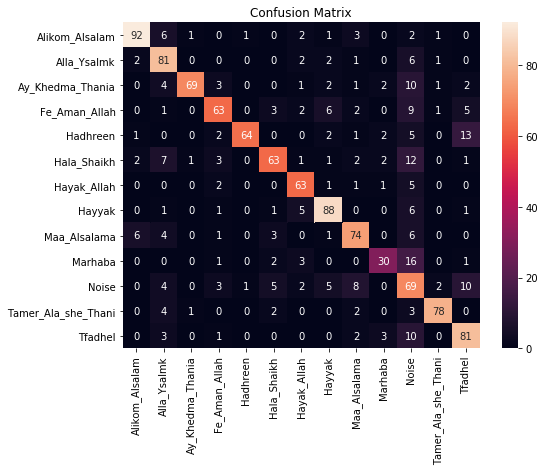

In [70]:
# np.set_printoptions(precision=2)
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels)


df_cm = pd.DataFrame(conf_mat, index = unique_labels,
                     columns = unique_labels)
plt.figure(figsize = (8,6))

sns.heatmap(conf_mat, annot=True, fmt='d', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Confusion Matrix')
# sns.heatmap(df_cm, annot=True, cmap='viridis')

# plt.show()

Text(0.5, 1, 'Normalized Confusion Matrix')

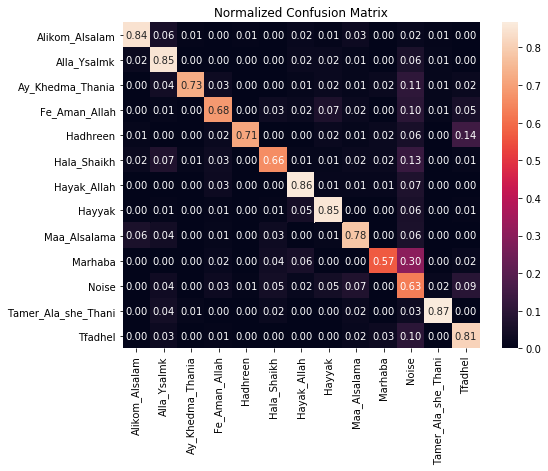

In [71]:
conf_mat = confusion_matrix(y_true_labels, y_pred_labels, labels=unique_labels)

conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] #Normalisation Happens here

df_cm = pd.DataFrame(conf_mat, index = unique_labels,
                     columns = unique_labels)
plt.figure(figsize = (8,6))
sns.heatmap(conf_mat, annot=True, fmt='.2f', xticklabels=unique_labels, yticklabels=unique_labels)
plt.title('Normalized Confusion Matrix')

In [81]:
y_pred=np.asarray(y_pred,dtype=np.float32)

In [82]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_hot[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_hot.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

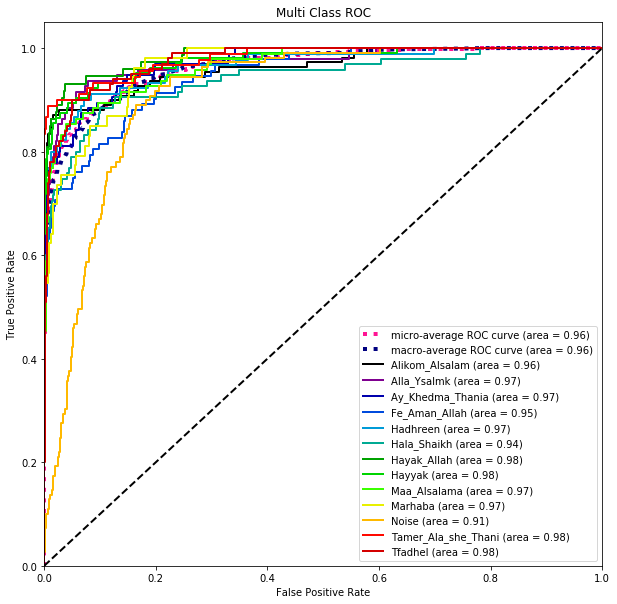

In [85]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = []
cm = pylab.get_cmap('nipy_spectral')
for i in range(n_classes):
    color = cm(1.*i/n_classes)
    colors.append(color)
unique_labels = np.unique(labels)

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:0.2f})'.format(unique_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi Class ROC')
legend = plt.legend()
legend._legend_box.align = "right"
plt.legend(loc="lower right")
plt.show()